## Install/Import libraries and define functions

#### Install/import libraries

In [1]:
#!pip install --upgrade pip
#!pip install scikeras[tensorflow]
#!pip install imblearn
#!pip install ecgmentations

import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
#import warnings 
#warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
import os
# Option 2: via Python logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import keras
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, GRU
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
#from imblearn.metrics import specificity_score
import seaborn as sns
import neurokit2 as nk
from scipy.signal import resample
from tqdm import tqdm
import pywt
from sklearn.preprocessing import RobustScaler
import ecgmentations as E
from keras.layers import Input
import pickle
import warnings
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import clone_model

2025-06-26 10:18:34.824568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750947514.934426  266099 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750947514.963963  266099 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750947515.246049  266099 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750947515.246064  266099 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750947515.246066  266099 computation_placer.cc:177] computation placer alr

#### Functions to scale signals

In [2]:
#Scaler by lead (RowsxColumns)
def robust_scaler(X, q_min=10, q_max=90):
    # X_np: shape (n_ecgs, n_leads, n_samples)
    n_ecgs, n_leads, n_samples = X.shape

    # 1. Flatten to 2D array of shape (n_ecgs * n_samples, n_leads)
    X_flat = X.transpose(0, 2, 1).reshape(-1, n_leads)

    # 2. Initialize and fit-transform the scaler
    scaler = RobustScaler(quantile_range=(q_min, q_max))
    X_flat_scaled = scaler.fit_transform(X_flat)

    # 3. Reshape back to original 3D shape, un-flatten and put axes back to (patients, leads, samples)
    X_scaled = (X_flat_scaled.reshape(n_patients, n_samples, n_leads).transpose(0, 2, 1))

    return X_scaled
    
def minmax_scaler(X, min_s=0, max_s=1):
    n_patients, n_leads, n_samples = X.shape
    # 1. bring leads to the last axis and flatten patients×samples into rows
    #    shape → (n_patients*n_samples, n_leads)
    flat = X.transpose(0, 2, 1).reshape(-1, n_leads)

    # 2. fit a single scaler so each column (lead) is scaled independently
    scaler = MinMaxScaler(feature_range=(min_s, max_s))
    flat_scaled = scaler.fit_transform(flat)

    # 3. un-flatten and put axes back to (patients, leads, samples)
    X_scaled = (flat_scaled.reshape(n_patients, n_samples, n_leads).transpose(0, 2, 1))
    # now X_scaled.shape = (672, 12, 500) and each lead is in [0,1]
    return X_scaled

def standard_scaler(X):
    n_patients, n_leads, n_samples = X.shape
    # 1. bring leads to the last axis and flatten patients×samples into rows
    #    shape → (n_patients*n_samples, n_leads)
    flat = X.transpose(0, 2, 1).reshape(-1, n_leads)

    # 2. fit a single scaler so each column (lead) is scaled independently
    scaler = StandardScaler()
    flat_scaled = scaler.fit_transform(flat)

    # 3. un-flatten and put axes back to (patients, leads, samples)
    X_scaled = (flat_scaled.reshape(n_patients, n_samples, n_leads).transpose(0, 2, 1))

    return X_scaled

### End of scaler by lead ##############

#Scalers by signal (rows)
def standard_scaler_rows(signals: np.ndarray) -> np.ndarray:
    signals = np.asarray(signals, dtype=float)
    n_ecgs, n_leads, n_samples = signals.shape
    scaled = np.zeros_like(signals)

    scaler = StandardScaler()
    for i in range(n_ecgs):
        for j in range(n_leads):
            # reshape to (n_samples, 1) for scaler
            lead_signal = signals[i, j, :].reshape(-1, 1)
            scaled_signal = scaler.fit_transform(lead_signal).ravel()
            scaled[i, j, :] = scaled_signal
    return scaled

def robust_scaler_rows(X, q_min=10, q_max=90):
    n_ecgs, n_leads, n_samples = X.shape
    # Initialize and fit-transform the scaler
    scaled = np.zeros_like(X)
    scaler = RobustScaler(quantile_range=(q_min, q_max))
    for i in range(n_ecgs):
        for j in range(n_leads):
            # reshape to (n_samples, 1) for scaler
            lead_signal = X[i, j, :].reshape(-1, 1)
            scaled_signal = scaler.fit_transform(lead_signal).ravel()
            scaled[i, j, :] = scaled_signal
    return scaled

def minmax_scaler_rows(X, q_min=0, q_max=1):
    n_ecgs, n_leads, n_samples = X.shape
    # Initialize and fit-transform the scaler
    scaled = np.zeros_like(X)
    scaler = MinMaxScaler(feature_range=(q_min, q_max))
    for i in range(n_ecgs):
        for j in range(n_leads):
            # reshape to (n_samples, 1) for scaler
            lead_signal = X[i, j, :].reshape(-1, 1)
            scaled_signal = scaler.fit_transform(lead_signal).ravel()
            scaled[i, j, :] = scaled_signal
    return scaled

### End of Scaler by signal (rows) ##########

#Scalers by time (columns)
def standard_scaler_time(signals: np.ndarray) -> np.ndarray:
    signals = np.asarray(signals, dtype=float)
    n_ecgs, n_leads, n_samples = signals.shape
    scaled = np.zeros_like(signals)
    scaler = StandardScaler()
    for i in range(n_leads):
        for j in range(n_samples):
            # reshape to (n_samples, 1) for scaler
            time_column = signals[:, i, j].reshape(-1, 1)
            scaled_signal = scaler.fit_transform(time_column).ravel()
            scaled[:, i, j] = scaled_signal
    return scaled

def robust_scaler_time(X, q_min=10, q_max=90):
    n_ecgs, n_leads, n_samples = X.shape
    # Initialize and fit-transform the scaler
    scaled = np.zeros_like(X)
    scaler = RobustScaler(quantile_range=(q_min, q_max))
    for i in range(n_leads):
        for j in range(n_samples):
            # reshape to (n_samples, 1) for scaler
            time_column = X[:, i, j].reshape(-1, 1)
            scaled_signal = scaler.fit_transform(time_column).ravel()
            scaled[:, i, j] = scaled_signal
    return scaled

def minmax_scaler_time(X, q_min=0, q_max=1):
    n_ecgs, n_leads, n_samples = X.shape
    # Initialize and fit-transform the scaler
    scaled = np.zeros_like(X)
    scaler = MinMaxScaler(feature_range=(q_min, q_max))
    for i in range(n_leads):
        for j in range(n_samples):
            # reshape to (n_samples, 1) for scaler
            time_column = X[:, i, j].reshape(-1, 1)
            scaled_signal = scaler.fit_transform(time_column).ravel()
            scaled[:, i, j] = scaled_signal
    return scaled

#### Functions to plot signals

In [3]:
def plot_random_ecg_histogram(ecgs: np.ndarray, bins: int = 50):
    n_ecgs, n_leads, n_samples = ecgs.shape

    # Choose a random ECG and a random lead
    ecg_idx = np.random.randint(n_ecgs)
    lead_idx = np.random.randint(n_leads)

    # Extract the chosen signal
    signal = ecgs[ecg_idx, lead_idx, :]

    # Get lead name from LEAD_ORDER
    lead_name = LEAD_ORDER[lead_idx]

    # Plot histogram
    plt.figure()
    plt.hist(signal, bins=bins, edgecolor='black')
    plt.title(f'Histogram of ECG No {ecg_idx}, Lead {lead_name}')
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.show()
    
def plot_compare_lead_histograms(ecg1: np.ndarray, ecg2: np.ndarray, title_prefix: str,rows: int = 4,cols: int = 3, bins: int = 50):
    if ecg1.shape != ecg2.shape:
        raise ValueError("Both ECG arrays must have the same shape.")
    n_ecgs, n_leads, n_samples = ecg1.shape
    total_plots = rows * cols
    if total_plots < n_leads:
        raise ValueError(f"Grid size {rows}×{cols}={total_plots} is too small for {n_leads} leads.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    # Ensure axes is a 2D array
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes[np.newaxis, :]
    elif cols == 1:
        axes = axes[:, np.newaxis]

    for lead_idx in range(n_leads):
        row_idx = lead_idx // cols
        col_idx = lead_idx % cols
        ax = axes[row_idx, col_idx]

        # Flatten all ECGs and samples for this lead
        data1 = ecg1[:, lead_idx, :].ravel()
        data2 = ecg2[:, lead_idx, :].ravel()

        # Compute shared bin edges based on combined data range
        vmin = min(data1.min(), data2.min())
        vmax = max(data1.max(), data2.max())
        bin_edges = np.linspace(vmin, vmax, bins + 1)

        # Plot histograms
        ax.hist(data1, bins=bin_edges, alpha=0.6, label='Orig. ECG', edgecolor='black')
        ax.hist(data2, bins=bin_edges, alpha=0.6, label='Augm. ECG', edgecolor='black')

        lead_name = LEAD_ORDER[lead_idx]
        ax.set_title(f"{title_prefix} {lead_name}")
        ax.set_xlabel("Amplitude")
        ax.set_ylabel("Frequency")
        ax.legend()

    # Hide any unused subplots
    for idx in range(n_leads, total_plots):
        r = idx // cols
        c = idx % cols
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_lead_histograms(ecgs: np.ndarray,title_prefix: str,rows: int = 4,cols: int = 3,bins: int = 50):
    n_ecgs, n_leads, n_samples = ecgs.shape
    total_plots = rows * cols
    if total_plots < n_leads:
        raise ValueError(f"Grid size {rows}×{cols}={total_plots} is too small for {n_leads} leads.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    # Ensure axes is 2D array for uniform indexing
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes[np.newaxis, :]
    elif cols == 1:
        axes = axes[:, np.newaxis]

    # Plot histogram for each lead
    for lead_idx in range(n_leads):
        row_idx = lead_idx // cols
        col_idx = lead_idx % cols
        ax = axes[row_idx, col_idx]

        # Gather all values for this lead across all ECGs
        data = ecgs[:, lead_idx, :].ravel()
        ax.hist(data, bins=bins, edgecolor='black')
        lead_name = LEAD_ORDER[lead_idx]
        ax.set_title(f"{title_prefix} {lead_name}".strip())
        ax.set_xlabel("Amplitude")
        ax.set_ylabel("Frequency")

    # Hide any unused subplots
    for idx in range(n_leads, total_plots):
        r = idx // cols
        c = idx % cols
        axes[r, c].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_random_ecg_wvlt(ecg_array: np.ndarray,
                                       wavelet: str,
                                       level: int,
                                       mode: str = 'periodic',
                                       sampling_rate: float = 500,
                                       random_state: int = None) -> None:
    n_ecgs, n_leads, n_samples = ecg_array.shape
    rng = np.random.default_rng(random_state)

    # Select a random ECG and lead
    idx_ecg = rng.integers(n_ecgs)
    idx_lead = rng.integers(n_leads)
    original = ecg_array[idx_ecg, idx_lead, :]

    # Reconstruct the approximation-only signal
    # 1. Get full coeff shapes from the original
    coeffs_full = pywt.wavedec(original, wavelet=wavelet, level=level, mode=mode)
    # Zero out all detail coefficients → keep only the smooth approximation
    coeffs_full[1:] = [np.zeros_like(detail) for detail in coeffs_full[1:]]
    # Reconstruct the signal
    reconstructed = pywt.waverec(coeffs_full, wavelet=wavelet, mode=mode)
    reconstructed = reconstructed[:n_samples]  # trim to original length

    # Time axis
    times = np.arange(n_samples) / sampling_rate

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(times, original)
    axes[0].set_title(f"Original ECG (Record {idx_ecg}, Lead {idx_lead})")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True)

    axes[1].plot(times, reconstructed)
    axes[1].set_title(f"Reconstructed Approximation (Level {level})")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


def plot_random_ecg(ecgs: np.ndarray):
    n_ecgs, n_leads, n_samples = ecgs.shape

    # Randomly choose an ECG and a lead
    ecg_idx = np.random.randint(n_ecgs)
    lead_idx = np.random.randint(n_leads)

    # Extract the chosen signal
    signal = ecgs[ecg_idx, lead_idx, :]

    # Plot
    plt.figure()
    plt.plot(signal)
    plt.title(f'ECG #{ecg_idx + 1}, Lead #{lead_idx + 1}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()
    
def plot_random_lead(ecgs: np.ndarray):
    n_ecgs, n_samples = ecgs.shape

    # Randomly choose an ECG and a lead
    ecg_idx = np.random.randint(n_ecgs)

    # Extract the chosen signal
    signal = ecgs[ecg_idx, :]

    # Plot
    plt.figure()
    plt.plot(signal)
    plt.title(f'ECG #{ecg_idx + 1}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()
    
def plot_exact_ecg_lead(ecgs: np.ndarray, ecg_idx: int, lead_idx: int):
    # Validate shape
    if ecgs.ndim != 3:
        raise ValueError("ecgs must be a 3D array of shape (n_ecgs, n_leads, n_samples)")

    n_ecgs, n_leads, n_samples = ecgs.shape

    # Validate indices
    if not (0 <= ecg_idx < n_ecgs):
        raise IndexError(f"ecg_idx must be between 0 and {n_ecgs - 1}")
    if not (0 <= lead_idx < n_leads):
        raise IndexError(f"lead_idx must be between 0 and {n_leads - 1}")

    # Extract and plot signal
    signal = ecgs[ecg_idx, lead_idx, :]
    plt.figure()
    plt.plot(signal)
    plt.title(f'ECG #{ecg_idx}, Lead #{lead_idx}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()
    
def plot_2random_ecgs(rytm_waves_np, mdn_waves_np):
    # Generate a random index for the ECG and the lead
    ecg_index = np.random.randint(0, rytm_waves_np.shape[0])
    lead_index = np.random.randint(0, rytm_waves_np.shape[1])

    #Choose the waveforms
    rhythm_waveform = rytm_waves_np[ecg_index,lead_index,:]
    median_waveform = mdn_waves_np[ecg_index,lead_index,:]

    #Plot median ECG
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.grid()
    sample_cnt = len(median_waveform)
    x_seconds = np.linspace(0, sample_cnt/ECG_SAMPLE_RATE, sample_cnt) 
    plt.plot(x_seconds, median_waveform)
    plt.title(f'SCA Pre-ECG No {ecg_index} - Lead {LEAD_ORDER[lead_index]}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('uV')

    #Plot median rhythm
    plt.subplot(1, 2, 2)
    plt.grid()
    sample_cnt = len(rhythm_waveform)
    x_seconds = np.linspace(0, sample_cnt/ECG_SAMPLE_RATE, sample_cnt) 
    plt.plot(x_seconds, rhythm_waveform)
    plt.title(f'SCA Pre-ECG No {ecg_index} - Lead {LEAD_ORDER[lead_index]}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('uV')
    plt.show()
    plt.close()

#### Functions to process ECG signals

In [4]:
def multilevel_approx_coeffs(ecg_array: np.ndarray,
                              wavelet: str,
                              level: int,
                              mode: str = 'symmetric') -> np.ndarray:
    """Apply a multilevel wavelet decomposition to each ECG lead in each recording,
    and return only the approximation coefficients at the specified level.
    """
    n_ecgs, n_leads, _ = ecg_array.shape

    # Precompute the length of the approximation coefficients by decomposing
    # a dummy signal of appropriate length
    dummy = ecg_array[0, 0]
    dummy_coeffs = pywt.wavedec(dummy, wavelet=wavelet, level=level, mode=mode)
    n_coeffs = len(dummy_coeffs[0])

    # Allocate output array
    approx_array = np.zeros((n_ecgs, n_leads, n_coeffs), dtype=float)

    # Loop over recordings and leads
    for i in range(n_ecgs):
        for j in range(n_leads):
            signal = ecg_array[i, j, :]
            coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level, mode=mode)
            approx_array[i, j, :] = coeffs[0]

    return approx_array
    
def undersample(crtg_np, stdg_np): 
    # 1) Determine class counts
    n_pos = stdg_np.shape[0]
    n_neg = crtg_np.shape[0]
    min_count = min(n_pos, n_neg)
    #Create labels
    ctrg_labels = np.zeros(n_neg)
    stdg_labels = np.ones(n_pos)

    # 2) Undersample the majority class
    np.random.seed(42)
    if n_neg > n_pos:
        # sample negative indices down to n_pos
        neg_idx = np.random.choice(n_neg, size=min_count, replace=False)
        crtg_sampled       =  crtg_np[neg_idx]
        ctrg_labels_sampled = ctrg_labels[neg_idx]
        stdg_sampled        = stdg_np
        stdg_labels_sampled = stdg_labels

    elif n_pos > n_neg:
        # sample positive indices down to n_neg
        pos_idx = np.random.choice(n_pos, size=min_count, replace=False)
        stdg_sampled        = stdg_np[pos_idx]
        stdg_labels_sampled = stdg_labels[pos_idx]
        crtg_sampled        = crtg_np
        ctrg_labels_sampled = ctrg_labels
    else:
        # already balanced
        stdg_sampled        = stdg_np
        stdg_labels_sampled = stdg_labels
        crtg_sampled        = crtg_np
        ctrg_labels_sampled = ctrg_labels

    # 3) Combine undersampled data
    X_balanced = np.concatenate([stdg_sampled, crtg_sampled], axis=0)
    y_balanced = np.concatenate([stdg_labels_sampled, ctrg_labels_sampled], axis=0)

    # 4) Shuffle the combined dataset
    indices = np.arange(X_balanced.shape[0])
    np.random.seed(42)
    np.random.shuffle(indices)
    X_undersampled_np = X_balanced[indices]
    y_undersampled_np = y_balanced[indices]
    
    return X_undersampled_np, y_undersampled_np

def apply_ecg_augmentation(ecg_array: np.ndarray, augmentation_fn) -> np.ndarray:
    # Unpack dimensions
    n_ecgs, n_leads, n_samples = ecg_array.shape

    # Prepare for augmentation: (n_ecgs, n_samples, n_leads)
    ecg_reshaped = np.transpose(ecg_array, (0, 2, 1))
    
    # Allocate container for augmented data
    ecg_augmented = np.zeros_like(ecg_reshaped)

    # Apply augmentation to each ECG
    for i in range(n_ecgs):
        result = augmentation_fn(ecg=ecg_reshaped[i])
        ecg_augmented[i] = result['ecg']

    # Return to original shape: (n_ecgs, n_leads, n_samples)
    return np.transpose(ecg_augmented, (0, 2, 1))

def segment_ecgs(rytm_waves_np, R_peaks_df_lst, time_width, sampling_rate):
    segments_list = []     #Start the segment list

    for ecg, Rpeaks_df in zip(rytm_waves_np, R_peaks_df_lst): # ecg has shape (n_leads, n_samples)
        #Get the Rpeaks indexes from the dataframe
        indexes_ecg_lst, sizes_ecg_lst = indexes_where_one(Rpeaks_df,'ECG_R_Peaks')
        #Get the robust-mode R peaks for the whole ECG
        opt_number_Rpeaks = robust_integer_mode(sizes_ecg_lst)
        #Get the best R peaks for the current ECG
        best_Rpeak_indexes_lst = get_best_Rpeaks_indexes(opt_number_Rpeaks, indexes_ecg_lst)
        #Segment the ECG
        segs = split_ecg_segments(ecg, best_Rpeak_indexes_lst, time_width, sampling_rate)
        if segs.size > 0:
            segments_list.append(segs)
    # Concatenate all the (n_i, n_leads, seg_len) arrays along the first axis
    if segments_list:
        segments_np = np.concatenate(segments_list, axis=0)
    else:
        # no segments found: produce an empty array with correct 3-D shape
        n_leads = OHCAw24h_rytm_waves_np.shape[1]
        seg_len = int(round(t * sampling_rate))
        segments_np = np.empty((0, n_leads, seg_len))
    
    return segments_np

def resample_ecgs(signals: np.ndarray, orig_sr: float, new_sr: float) -> np.ndarray:
    # Ensure input is a NumPy array
    signals = np.asarray(signals)
    if signals.ndim != 3:
        raise ValueError("signals must be a 3D array of shape (n_ecgs, n_leads, n_samples)")

    n_ecgs, n_leads, n_samples = signals.shape
    # Compute the number of samples at the new rate
    duration = n_samples / orig_sr
    new_n_samples = int(round(duration * new_sr))

    # Pre-allocate output array
    resampled = np.empty((n_ecgs, n_leads, new_n_samples), dtype=signals.dtype)

    # Resample each ECG and each lead
    for i in range(n_ecgs):
        # axis=1→leads, axis=0→ECG index; we resample along axis=2 (time)
        resampled[i] = resample(signals[i], num=new_n_samples, axis=1)

    return resampled

def check_missing_values(df):
    # Check for missing values in the dataframe
    missing_values = df.isnull().any()
    # Check the count of missing values in each column
    missing_values_count = df.isnull().sum()
    print("\nCount of missing values in each column:")
    print(missing_values_count)

def clean_ecgs(waveforms, sampling_rate, method):
    # Initialize an empty array for the filtered ECGs
    filtered = np.zeros_like(waveforms)

    # Apply the filtering function to each ECG and lead
    for i in range(waveforms.shape[0]):       # Loop over each ECG
        for j in range(waveforms.shape[1]):   # Loop over each lead
            # Filter the lead waveform using nk.ecg_process
            filtered[i, j, :] = nk.ecg_clean(waveforms[i, j, :], sampling_rate=sampling_rate, method=method)
    
    return filtered

def get_ecg_Rpeaks(waveforms, sampling_rate, method, clean=True, correct_artifacts=False, show=False):
    R_peaks_lst = []  # List to store processed each ECGs 
    # Apply the filtering function to each ECG and lead
    for i in range(waveforms.shape[0]):       # Loop over each ECG
        lead_peaks_lst = []  # List to store processed leads
        for j in range(waveforms.shape[1]):   # Loop over each lead
            # Clean the lead waveform using nk.clean_ecg
            #print('Next process: lead', LEAD_ORDER[j])
            if clean :
                lead = nk.ecg_clean(waveforms[i, j, :], sampling_rate=sampling_rate, method=method)
            else:
                lead = waveforms[i, j, :]
                
            lead_Rpeaks_df, info = nk.ecg_peaks(lead, sampling_rate=sampling_rate, method=method, 
                                      correct_artifacts=correct_artifacts, show=show)
            #Print lead and np index if process went through        
            #print(info)
            lead_peaks_lst.append(lead_Rpeaks_df)    # Append the processed dataframes to their respective lists               
        #After finished all leads, append the lead list to the ECG list and continue next ECG.
        R_peaks_lst.append(lead_peaks_lst)
    
    return R_peaks_lst

def robust_integer_mode(values):
    vals = sorted(values)
    n = len(vals)
    h = n // 2 + 1

    # Step 2: find start of narrowest half-sample window
    best_i, best_range = 0, float('inf')
    for i in range(n - h + 1):
        r = vals[i + h - 1] - vals[i]
        if r < best_range:
            best_range = r
            best_i = i

    window = vals[best_i:best_i + h]

    # Step 3: frequencies inside the window
    from collections import Counter
    counts = Counter(window)
    max_freq = max(counts.values())
    modes = [v for v, c in counts.items() if c == max_freq]

    # Step 4: deterministic tie-break
    if len(modes) == 1:
        return modes[0]
    centre = (window[0] + window[-1]) / 2
    modes.sort(key=lambda v: (abs(v - centre), v))
    return modes[0]

def indexes_where_one(df_list, column_name):
    index_list = []
    sizes_list = []
    for i in range(len(df_list)):
        indexes_lst = df_list[i].index[df_list[i][column_name] == 1].tolist()
        #print(indexes_lst)
        index_list.append(indexes_lst)
        sizes_list.append(len(indexes_lst))        
        
    return index_list, sizes_list

def get_best_Rpeaks_indexes(opt_nRpeaks, indexes_ecg_lst):
    #Find the best optimal n R peaks indexes
    best_Rpeak_indexes = []
    for n in range(opt_nRpeaks):
    #Get the nth-Rpeak indexes. In the nested list, the columns represent the n-th R-peak and the rows the i-th lead in each ECG
        indexes_nRpeak_lst = []
        for index in indexes_ecg_lst:
            #print('current n:', n, 'current row size:', len(index))
            if len(index) <= n:
                indexes_nRpeak_lst.append(0)
            else:
                indexes_nRpeak_lst.append(index[n])
        best_Rpeak = robust_integer_mode(indexes_nRpeak_lst)
        best_Rpeak_indexes.append(best_Rpeak)
    return best_Rpeak_indexes

def split_ecg_segments(signals: np.ndarray,
                       r_peaks: list[int],
                       width_sec: float,
                       fs: float) -> np.ndarray:
    n_leads, n_samples = signals.shape

    # number of samples per segment
    seg_samples = int(round(width_sec * fs))
    # split window so that R is near center
    half_before = seg_samples // 2
    half_after  = seg_samples - half_before - 1

    segments = []
    for r in r_peaks:
        start = r - half_before
        end   = r + half_after + 1  # end is exclusive
        # discard if out of bounds
        if start < 0 or end > n_samples:
            continue
        # slice out all leads for this window
        seg = signals[:, start:end]  # shape (n_leads, seg_samples)
        if seg.shape[1] == seg_samples:
            segments.append(seg)

    if not segments:
        # no valid segments found
        return np.empty((0, n_leads, seg_samples))

    # stack into final array of shape (n_segments, n_leads, seg_samples)
    return np.stack(segments, axis=0)

#### Functions to evaluate models

In [5]:
# Define a model‐builder function that returns a fresh copy of `model` each time:
def get_fresh_model():
    # Clone the architecture of the existing `model`
    new_model = clone_model(model)
    # Compile it with the same optimizer/loss/metrics as the original
    new_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[ 'accuracy' ]  # or ['accuracy', F1Score()] if you want F1 as well
    )
    return new_model

def kfold_rnn_cv(model_fn,
                 X_train: np.ndarray,
                 y_train: np.ndarray,
                 k_folds: int,
                 batch_size: int,
                 epochs: int,
                 optimization_metric: str = 'accuracy'):
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    acc_list = []
    prec_list = []
    sens_list = []
    spec_list = []
    f1_list = []
    npv_list = []
    auroc_list = []

    # Will store per-fold history dictionaries
    histories = []

    # Loop over folds with tqdm
    for train_idx, val_idx in tqdm(
        skf.split(X_train, y_train),
        total=k_folds,
        desc='CV Folds',
        ncols=70
    ):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Fresh model for this fold
        model = model_fn()

        # Train and record history
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )
        histories.append(history.history)

        # Predict and compute metrics
        y_prob = model.predict(X_val, verbose=0)
        y_pred = (y_prob >= 0.5).astype(int).ravel()

        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, zero_division=0)
        sens = recall_score(y_val, y_pred, zero_division=0)
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        f1m  = f1_score(y_val, y_pred, zero_division=0)
        npv  = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        auroc  = roc_auc_score(y_val, y_pred)

        
        acc_list.append(acc)
        prec_list.append(prec)
        sens_list.append(sens)
        spec_list.append(spec)
        f1_list.append(f1m)
        npv_list.append(npv)
        auroc_list.append(auroc)
        
    # Aggregate and print mean ± std for each metric
    def print_metric(name, values):
        mean = np.mean(values)
        std  = np.std(values)
        print(f"{name}: {mean:.4f} ± {std:.4f}")

    print_metric("Accuracy",        acc_list)
    print_metric("Precision",       prec_list)
    print_metric("Sensitivity",     sens_list)
    print_metric("Specificity",     spec_list)
    print_metric("F1-Score",        f1_list)
    print_metric("NPV", npv_list)
    print_metric("AUROC", auroc_list)

    # --- Plot average learning curves across folds ---
    # Extract per-epoch arrays for loss and chosen metric
    train_loss = np.array([h['loss'] for h in histories])            # shape: (k_folds, epochs)
    val_loss   = np.array([h['val_loss'] for h in histories])        # shape: (k_folds, epochs)

    train_metric = np.array([h[optimization_metric] for h in histories])
    val_metric   = np.array([h[f'val_{optimization_metric}'] for h in histories])

    # Compute mean and std across folds
    loss_mean_train = np.mean(train_loss, axis=0)
    loss_mean_val   = np.mean(val_loss, axis=0)
    metric_mean_train = np.mean(train_metric, axis=0)
    metric_mean_val   = np.mean(val_metric, axis=0)

    loss_std_train = np.std(train_loss, axis=0)
    loss_std_val   = np.std(val_loss, axis=0)
    metric_std_train = np.std(train_metric, axis=0)
    metric_std_val   = np.std(val_metric, axis=0)

    epochs_arr = np.arange(1, epochs + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation loss with shaded std
    axes[0].plot(epochs_arr, loss_mean_train, label='Train Loss')
    axes[0].fill_between(
        epochs_arr,
        loss_mean_train - loss_std_train,
        loss_mean_train + loss_std_train,
        alpha=0.3
    )
    axes[0].plot(epochs_arr, loss_mean_val, label='Val Loss')
    axes[0].fill_between(
        epochs_arr,
        loss_mean_val - loss_std_val,
        loss_mean_val + loss_std_val,
        alpha=0.3
    )
    axes[0].set_title('Average Loss Across Folds')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot training & validation metric with shaded std
    axes[1].plot(epochs_arr, metric_mean_train, label=f'Train {optimization_metric}')
    axes[1].fill_between(
        epochs_arr,
        metric_mean_train - metric_std_train,
        metric_mean_train + metric_std_train,
        alpha=0.3
    )
    axes[1].plot(epochs_arr, metric_mean_val, label=f'Val {optimization_metric}')
    axes[1].fill_between(
        epochs_arr,
        metric_mean_val - metric_std_val,
        metric_mean_val + metric_std_val,
        alpha=0.3
    )
    axes[1].set_title(f'Average {optimization_metric.capitalize()} Across Folds')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel(optimization_metric.capitalize())
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
# ---------- Custom F1 Score Metric ----------
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='F1-score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred_bin)
        fp = tf.reduce_sum((1 - y_true) * y_pred_bin)
        fn = tf.reduce_sum(y_true * (1 - y_pred_bin))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + K.epsilon())
        recall    = self.tp / (self.tp + self.fn + K.epsilon())
        return 2 * precision * recall / (precision + recall + K.epsilon())

    def reset_state(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

# ---------- TQDM ProgressBar Callback ----------
class TqdmProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progbar = tqdm(
            total=self.epochs,
            desc='Training',
            unit='epoch',
            bar_format='{l_bar}{bar} | {n_fmt}/{total_fmt}'
        )
    def on_epoch_end(self, epoch, logs=None):
        self.progbar.update(1)
    def on_train_end(self, logs=None):
        self.progbar.close()

# ---------- Plot History Function ----------
def plot_keras_history(history, test_metric: float, test_loss: float, metric: str = 'Accuracy'):
    # Determine metric string
    if metric == 'F1-score':
        metric_str = 'F1-score'
    elif metric == 'Accuracy':
        metric_str = 'accuracy'
    else:
        raise ValueError("metric must be 'Accuracy' or 'F1-score'")

    hist = history.history
    train_loss = hist['loss']
    val_loss   = hist['val_loss']
    train_metric = hist[metric_str]
    val_metric   = hist[f'val_{metric_str}']
    epochs_arr = np.arange(1, len(train_loss) + 1)
    abs_loss_diff = np.abs(np.array(val_loss) - np.array(train_loss))
    last_epoch = epochs_arr[-1]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Top-left: Loss curves + Test Loss
    axes[0, 0].plot(epochs_arr, train_loss, label='Train Loss')
    axes[0, 0].plot(epochs_arr, val_loss,   label='Val Loss')
    axes[0, 0].plot(last_epoch, test_loss, 'ro', label='Test Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Top-right: metric curves + Test metric
    axes[0, 1].plot(epochs_arr, train_metric, label=f'Train {metric}')
    axes[0, 1].plot(epochs_arr, val_metric,   label=f'Val {metric}')
    axes[0, 1].plot(last_epoch, test_metric, 'ro', label=f'Test {metric}')
    axes[0, 1].set_title(f'Training & Validation {metric}')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel(metric)
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Bottom-left: Val vs Train metric scatter with epoch gradient
    scatter = axes[1, 0].scatter(
        train_metric, val_metric,
        c=epochs_arr,
        cmap='viridis_r',
        alpha=0.8
    )
    min_m = min(min(train_metric), min(val_metric))
    max_m = max(max(train_metric), max(val_metric))
    axes[1, 0].plot([min_m, max_m], [min_m, max_m], 'k--', linewidth=1)
    axes[1, 0].set_title(f'Val vs. Train {metric} (Epoch Gradient)')
    axes[1, 0].set_xlabel(f'Train {metric}')
    axes[1, 0].set_ylabel(f'Val {metric}')
    axes[1, 0].grid(True)
    fig.colorbar(scatter, ax=axes[1, 0], label='Epoch')

    # Bottom-right: Absolute Loss Difference
    axes[1, 1].plot(epochs_arr, abs_loss_diff, marker='o')
    axes[1, 1].set_title('Absolute Loss Difference')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('|Val Loss – Train Loss|')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# ---------- Main Training Function with Resume ----------
def train_rnn_with_resume(metric: str,
    X_train, X_test, y_train, y_test,
    samples_per_signal, model_leads,
    dl_units, batch_size, epochs,
    RNN_activation='tanh',
    last_layer_activation='sigmoid',
    dl_model=SimpleRNN,
    drop_rate=0.0,
    continue_from_last_iteration=False):
    # Paths for saving
    history_path = 'training_history.pkl'
    weights_path = 'model.weights.h5'

    # Build model architecture
    model = Sequential([
        Input(shape=(samples_per_signal, model_leads)),
        dl_model(dl_units, activation=RNN_activation),
        Dropout(drop_rate),
        Dense(1, activation=last_layer_activation)
    ])

    # Determine metric object from string
    if metric == 'F1-score':
        metric_obj = F1Score()
    elif metric == 'Accuracy':
        metric_obj = 'accuracy'
    else:
        raise ValueError("metric must be 'Accuracy' or 'F1-score'")

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[metric_obj]
    )

    # Initialize or load history
    initial_epoch = 0
    if continue_from_last_iteration and os.path.exists(history_path) and os.path.exists(weights_path):
        with open(history_path, 'rb') as f:
            saved_history = pickle.load(f)
        completed_epochs = len(saved_history['loss'])
        initial_epoch    = completed_epochs
        model.load_weights(weights_path)
        print(f"Resuming training from epoch {initial_epoch}...")
    else:
        # Initialize empty history keys matching chosen metric
        saved_history = {'loss': [], 'val_loss': []}
        if metric == 'F1-score':
            saved_history.update({'f1_score': [], 'val_f1_score': []})
        else:  # accuracy
            saved_history.update({'accuracy': [], 'val_accuracy': []})
        #Delete history files
        files_to_delete = [history_path, weights_path]
        for file_path in files_to_delete:
            if os.path.exists(file_path):
                try:
                    os.remove(file_path)
                except OSError as e:
                    print(f"Error deleting {file_path}: {e}")
            else:
                print(f"File not found: {file_path}")

    # Train
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        initial_epoch=initial_epoch,
        batch_size=batch_size,
        verbose=0,
        callbacks=[TqdmProgressBar()]
    )

    # Combine old & new history
    for key, values in history.history.items():
        if key not in saved_history:
            saved_history[key] = []
        saved_history[key].extend(values)

    # Save combined history and weights
    with open(history_path, 'wb') as f:
        pickle.dump(saved_history, f)
    model.save_weights(weights_path)

    # Evaluate on test set
    test_loss, test_metric = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {test_loss:.3f}, Test {metric}: {test_metric:.3f}")

    # Plot combined history
    class _TempHistory:
        def __init__(self, hist_dict):
            self.history = hist_dict

    plot_keras_history(
        _TempHistory(saved_history),
        test_metric, 
        test_loss,
        metric=metric
    )

    return model, saved_history, test_loss, test_metric

# Define the custom npv and specificitymetrics
def calculate_npv_spec(y, y_pred):
    # Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    # Calculate NPV
    npv = tn / (tn + fn)
    spec = tn/(tn + fp)

    return npv, spec 

def model_eval(model, X): 
    #Capture the data type in X: X_'data_type'
    X_name = get_variable_name(X)    #Capture the name of X
    # Extract the 'name' part from 'X_name' by removing the 'X_' prefix
    name = X_name.split("X_", 1)[-1]  # This gives us "example"
    # Construct the corresponding 'y_' variable name
    y_name = f"y_{name}"
    # Use globals() to get the variable content
    y = globals().get(y_name)
    
    #Make prediction based on model and input X
    y_pred_prob = model.predict(X, verbose=0)
    #Calculate the proper prediction depending on 1 or 2 model outputs
    if y_pred_prob.shape[1] == 1:
        y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
    elif y_pred_prob.shape[1] == 2:
        y_pred = np.argmax(y_pred_prob, axis=1) #change form 2-bit label to 1-bit
        y = np.argmax(y, axis=1)
    else :
        print('Incorrect dimension for prediction of predictors')
        return
    
    #Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    npv, specificity = calculate_npv_spec(y, y_pred)
    auroc = roc_auc_score(y, y_pred)

    
    data_type = {'val': 'Validation', 'train': 'Training', 'test': 'Testing'}[name]
    
    #Print results
    print(data_type, ' metrics:')
    print('Accuracy: {:.3f}'.format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Sensitivity: {:.3f}".format(recall))
    print("Specificity: {:.3f}".format(specificity))
    print("F1-Score: {:.3f}".format(f1))
    print("NPV: {:.3f}".format(npv))
    print("AUROC: {:.3f}".format(auroc))

    #Plot confusion matrix
    cm = plot_confusion_matrix(y, y_pred, data_type)

    return cm

    # Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {set_name}')
    plt.show()
    
    return cm

def get_variable_name(value):
    for name, val in globals().items():
        if val is value:
            return name
    return None

def print_rnn_model_details(model):
    if not isinstance(model, tf.keras.Model):
        print("Error: The provided object is not a TensorFlow Keras model.")
        return

    print("--- Model Architecture Summary ---")
    model.summary() # Prints a summary of the model's layers

    print("--- RNN Layer Details ---")
    rnn_layer_found = False
    last_layer_activation = "N/A"

    for i, layer in enumerate(model.layers):
        # Check for common RNN layer types
        if isinstance(layer, (SimpleRNN, LSTM, GRU)):
            rnn_layer_found = True
            print(f"  RNN Layer Type: {type(layer).__name__}")
            print(f"  Number of RNN Units: {layer.units}")
            if hasattr(layer, 'activation'):
                print(f"  RNN Activation Function: {layer.activation.__name__ if layer.activation else 'None'}")
            else:
                print("  RNN Activation Function: Not directly specified (e.g., for LSTM/GRU inner activations)")
        
        # Check for the last layer's activation function
        if i == len(model.layers) - 1:
            if hasattr(layer, 'activation'):
                last_layer_activation = layer.activation.__name__ if layer.activation else 'None'
            else:
                last_layer_activation = "No explicit activation (e.g., for output layers without activation)"

    if not rnn_layer_found:
        print("  No explicit SimpleRNN, LSTM, or GRU layer found in the model.")

    print(f"--- Last Layer Activation Function: {last_layer_activation} ---")

#### Function to retrieve data from dataset

In [6]:
def load_outcomes_df(fp):
    '''Load outcomes'''
    df = pd.read_csv(fp)

    # Convert to datetime
    date_cols = [c for c in df.columns if '_offset' in c]
    for c in date_cols:
        df[c] = pd.to_datetime(df[c], format='ISO8601')

    print('Loaded {}: {}'.format(fp, df.shape))
    return df

def load_study_group_rhythm_ecgs():
    '''Load Study Group rhythm, median, ECGs npy and lookup CSV'''
    ecg_rhythm_fp = os.path.join(DATA_DIR, 'study-group','ecg-waveforms','waveform-rhythm.npy')
    waveform_rhythm_npy = np.load(ecg_rhythm_fp)
    print('Loaded {}: {}'.format(ecg_rhythm_fp, waveform_rhythm_npy.shape))
    
    ecg_median_fp = os.path.join(DATA_DIR, 'study-group','ecg-waveforms','waveform-median.npy')
    waveform_median_npy = np.load(ecg_median_fp)
    print('Loaded {}: {}'.format(ecg_median_fp, waveform_median_npy.shape))
    
    ecg_lookup_fp = os.path.join(DATA_DIR, 'study-group','ecg-waveforms','waveform-npy.csv')
    waveform_npy_df = pd.read_csv(ecg_lookup_fp)
    print('Loaded {}: {}'.format(ecg_lookup_fp, waveform_npy_df.shape))
    
    return waveform_rhythm_npy, waveform_median_npy, waveform_npy_df

def load_study_group_outcomes():
    # Load all Study Group files
    cohort_fp = os.path.join(DATA_DIR, 'study-group','cohort.csv')
    cohort_df = load_outcomes_df(cohort_fp)

    comorbidities_fp = os.path.join(DATA_DIR, 'study-group','comorbidities.csv')
    comorbidities_df = load_outcomes_df(comorbidities_fp)

    ecg_fp = os.path.join(DATA_DIR, 'study-group','ecg.csv')
    ecg_df = load_outcomes_df(ecg_fp)

    rosc_outcomes_fp = os.path.join(DATA_DIR, 'study-group','rosc-outcomes.csv')
    rosc_outcomes_df = load_outcomes_df(rosc_outcomes_fp)

    study_group_df = reduce(lambda left,right: pd.merge(left, right, on=['patient_ngsci_id', 'year', 'ecg_id'],
                                                        how='outer'), [cohort_df, comorbidities_df, ecg_df, rosc_outcomes_df])
    print('`study_group_df`: {}'.format(study_group_df.shape))
    study_group_df_lookup = {
        'study_group_df': study_group_df,
        'cohort_df': cohort_df,
        'comorbidities_df': comorbidities_df,
        'ecg_df': ecg_df,
        'rosc_outcomes_df': rosc_outcomes_df
    }
    return study_group_df_lookup

def load_control_group_outcomes():
    # Load Control Group files
    ecg_cohort_fp = os.path.join(DATA_DIR, 'control-group','ecg-cohort.csv')
    ecg_cohort_df = load_outcomes_df(ecg_cohort_fp)

    return ecg_cohort_df

def load_control_pre_ecgs(year):
    '''Load Control Group rhythm ECGs npy and lookup CSV'''
    # rhtythm-Waveforms - pre
    fp = os.path.join(DATA_DIR, 'control-group/{}/pre/ecg-waveforms/waveform-rhythm.npy'.format(year))
    ecg_rhythm_npy_pre = np.load(fp)
    print('Loaded {}: {}'.format(fp, ecg_rhythm_npy_pre.shape))
    
    # median-Waveforms - pre
    fp = os.path.join(DATA_DIR, 'control-group/{}/pre/ecg-waveforms/waveform-median.npy'.format(year))
    ecg_median_npy_pre = np.load(fp)
    print('Loaded {}: {}'.format(fp, ecg_median_npy_pre.shape))
    
    # Waveform lookup df - pre
    fp = os.path.join(DATA_DIR, 'control-group/{}/pre/ecg-waveforms/waveform-npy.csv'.format(year))
    ecg_npy_df_pre = pd.read_csv(fp)
    print('Loaded {}: {}'.format(fp, ecg_npy_df_pre.shape))
    ecg_npy_df_pre['ecg_timetag'] = 'pre'
    
    return ecg_rhythm_npy_pre, ecg_median_npy_pre, ecg_npy_df_pre

def choose_waveforms(original_np_array, np_indexes, lead_indices):
    # Initialize an empty list to store the filtered waveforms
    filtered_waveforms = []

    # Loop over the lead indices
    for lead_idx in lead_indices:
        # Retrieve data for all np_indexes in the first dimension and the current lead in the second dimension
        waveforms_lead = original_np_array[np_indexes, lead_idx, :]
        
        # Append the result to the list
        filtered_waveforms.append(waveforms_lead)

    # Convert the list to a numpy array and stack along a new axis (for the lead dimension)
    filtered_waveforms = np.stack(filtered_waveforms, axis=1)

    return filtered_waveforms

### Global Variables

In [7]:
DATA_DIR = os.path.join('/','home','x-heinercg','v1')
LEAD_ORDER = ['I', 'II', 'III',
              'aVR', 'aVL', 'aVF',
              'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
LEAD_INDEX = {lead: i for i, lead in enumerate(LEAD_ORDER)}
ECG_CAPTURE_TIME = 10  # Each ECG is taken for 10 seconds
ECG_SAMPLE_RATE = 500 # Each ECG is sampled at 500 Hz
sampling_rate = ECG_SAMPLE_RATE 

## Select waveforms from Study Group within the time window
###### Output: OHCAw24h_rytm_waves_np

In [8]:
#Read the waveform signals
stdg_rhythm_np, stdg_median_np, waveform_index_df = load_study_group_rhythm_ecgs()

#Filter out the waveforms
#Read the filter

# Study group 24h filter
filter_dir = os.path.join('/','home','x-heinercg','Thesis_code','csv_files_and_generators')
fltr_OHCA_preECG_within24h = pd.read_csv(os.path.join(filter_dir,'v2_fltr_OHCA_preECG_within24h.csv'))

#Apply filters
waveIndexes_OHCA_preECGs_w24h = pd.merge(waveform_index_df,
                                         fltr_OHCA_preECG_within24h,\
                                     on='ecg_id')
# waveIndexes_OHCA_preECGs_w24h contains the waveform indexes 'npy_index'
# stdg_rhythm_np contains the waveform data.
# stdg_rhythm_np needs two indexes to retrieve a waveform ex. [np_index][lead_index_1]

#Get the indexes
preECGs_OHCA_w24 = waveIndexes_OHCA_preECGs_w24h.shape[0]

#Check results
print('Total number of ECG indexes retrieved: ', preECGs_OHCA_w24)
check_missing_values(waveIndexes_OHCA_preECGs_w24h)
waveIndexes_OHCA_preECGs_w24h['ecg_timetag'].value_counts()

Loaded /home/x-heinercg/v1/study-group/ecg-waveforms/waveform-rhythm.npy: (1686, 12, 5000)
Loaded /home/x-heinercg/v1/study-group/ecg-waveforms/waveform-median.npy: (1686, 12, 600)
Loaded /home/x-heinercg/v1/study-group/ecg-waveforms/waveform-npy.csv: (1686, 4)
Total number of ECG indexes retrieved:  23

Count of missing values in each column:
ecg_id              0
year                0
npy_index           0
ecg_timetag         0
patient_ngsci_id    0
sex                 0
age                 0
dtype: int64


ecg_timetag
[0]pre    23
Name: count, dtype: int64

The shape of rhythm-OHCA ECGs inside the time window is:  (23, 12, 5000)
The shape of median-OHCA ECGs inside the time window is:  (23, 12, 600)


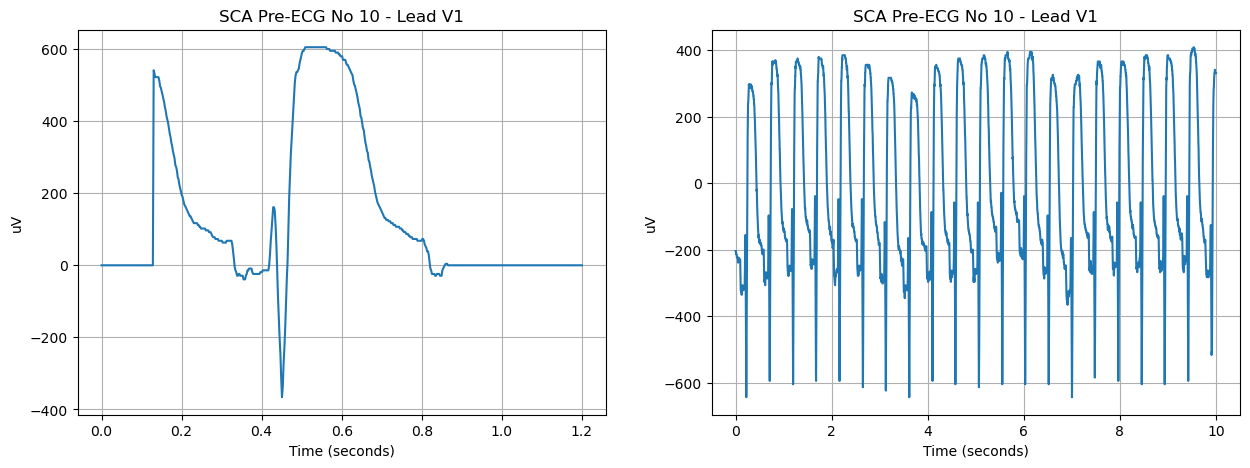

In [9]:
#Retrieve the waveform indexes from the study group according to the filter.
np_indexes = waveIndexes_OHCA_preECGs_w24h['npy_index'].values

# Define the lead indices
#lead_indices = [LEAD_INDEX['II'], LEAD_INDEX['V1']]

#Choose all leads
lead_indices = [LEAD_INDEX[i] for i in LEAD_ORDER]

#Choose waveforms
OHCAw24h_rytm_waves_np = choose_waveforms(stdg_rhythm_np, np_indexes, lead_indices)
OHCAw24h_mdn_waves_np = choose_waveforms(stdg_median_np, np_indexes, lead_indices)

print('The shape of rhythm-OHCA ECGs inside the time window is: ', OHCAw24h_rytm_waves_np.shape)
print('The shape of median-OHCA ECGs inside the time window is: ', OHCAw24h_mdn_waves_np.shape)

#Plot a rhythm and median signal 
plot_2random_ecgs(OHCAw24h_rytm_waves_np, OHCAw24h_mdn_waves_np)

## Select waveforms from Control Group within the time window
###### Output: ctrg_rhythm_waveforms_np

In [10]:
#Load control group data
control_group_df = load_control_group_outcomes()

#Get the pre-ecg information 
control_group_df = control_group_df[control_group_df['ecg_timetag']=='pre']
#control_group_df

Loaded /home/x-heinercg/v1/control-group/ecg-cohort.csv: (16386, 8)


In [11]:
#Get all waveforms data
# Save the control group years as a set
ctrg_years = sorted(['2015', '2016', '2017', '2018', '2019'])
# Create variables to store the data
preECG_indexes_list = []
ctrg_rhythm_npy_dict = {}  # Initialize the dictionary outside the loop
ctrg_median_npy_dict = {}  # Initialize the dictionary outside the loop

# Retrieve waveforms for all years
# 1. `ctrg_rhythm_npy_dict` storing the waveforms with the year as the key.
# 2. `ecg_all_years_pre_df` containing all the dataframes combined.
for year in ctrg_years:
    # Load waveforms
    preECG_rhythm_np, preECG_median_np, preECG_indexes_df = load_control_pre_ecgs(year)
    
    # Update dictionaries with year as the key and waveforms as the value
    ctrg_rhythm_npy_dict[year] = preECG_rhythm_np
    ctrg_median_npy_dict[year] = preECG_median_np
    
    # Append the dataframe to the list
    preECG_indexes_list.append(preECG_indexes_df)

# Save all dataframes in a single dataframe
preECG_all_years_df = pd.concat(preECG_indexes_list, ignore_index=True)

Loaded /home/x-heinercg/v1/control-group/2015/pre/ecg-waveforms/waveform-rhythm.npy: (1046, 12, 5000)
Loaded /home/x-heinercg/v1/control-group/2015/pre/ecg-waveforms/waveform-median.npy: (1046, 12, 600)
Loaded /home/x-heinercg/v1/control-group/2015/pre/ecg-waveforms/waveform-npy.csv: (1046, 4)
Loaded /home/x-heinercg/v1/control-group/2016/pre/ecg-waveforms/waveform-rhythm.npy: (1238, 12, 5000)
Loaded /home/x-heinercg/v1/control-group/2016/pre/ecg-waveforms/waveform-median.npy: (1238, 12, 600)
Loaded /home/x-heinercg/v1/control-group/2016/pre/ecg-waveforms/waveform-npy.csv: (1238, 4)
Loaded /home/x-heinercg/v1/control-group/2017/pre/ecg-waveforms/waveform-rhythm.npy: (1269, 12, 5000)
Loaded /home/x-heinercg/v1/control-group/2017/pre/ecg-waveforms/waveform-median.npy: (1269, 12, 600)
Loaded /home/x-heinercg/v1/control-group/2017/pre/ecg-waveforms/waveform-npy.csv: (1269, 4)
Loaded /home/x-heinercg/v1/control-group/2018/pre/ecg-waveforms/waveform-rhythm.npy: (1410, 12, 5000)
Loaded /home/

In [12]:
#Apply the control group filter
#Read the control group filter
fltr_control_preECG_within7d = pd.read_csv(os.path.join(filter_dir,'fltr_ctrg_preECG_within_7days.csv'))
#Read the control group filter 30 days
#fltr_control_preECG_within7d = pd.read_csv('fltr_ctrg_preECG_30days.csv')
#Filter data out.
ctrg_fltrd_years_df = pd.merge(preECG_all_years_df, fltr_control_preECG_within7d, on = 'ecg_id')
#ctrg_fltrd_years_df contains the indexes per year of the control group waveforms.
#ctrg_rhythm_npy_dict contains the waveforms with the year as the key.
#ctrg_rhythm_npy_dict needs a year (key) and two indexes to retrieve a waveform ex. [np_index][lead_index_1]

#Create the Control Group labels
crtg_ECGs = ctrg_fltrd_years_df.shape[0]
print('The total number of control ECGs is: ', crtg_ECGs)

The total number of control ECGs is:  247


The shape of the rhythm ECG array is:  (247, 12, 5000)
The shape of the median ECG array is:  (247, 12, 600)


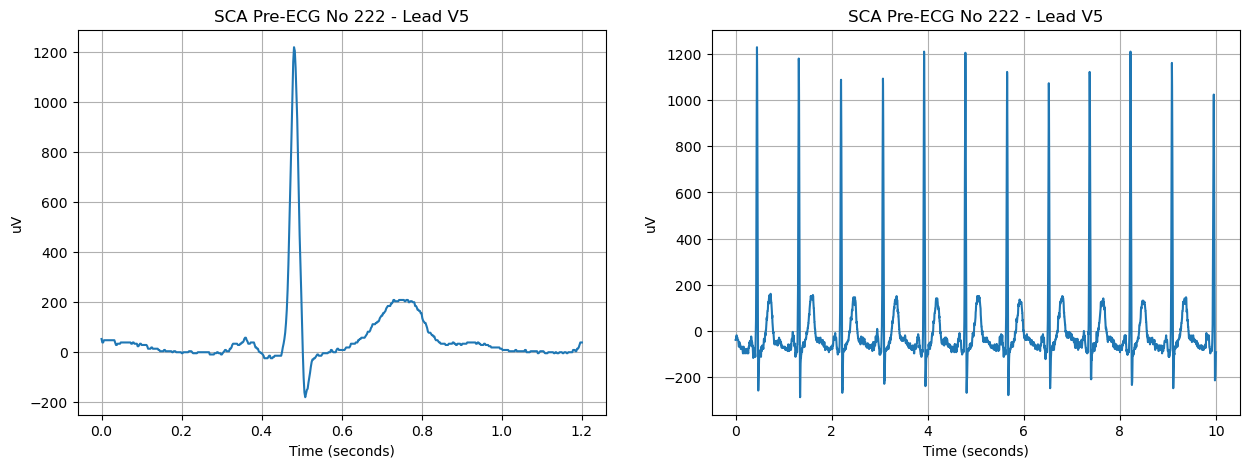

In [13]:
#get the years where data exist
year_list = sorted(ctrg_fltrd_years_df['year'].unique().tolist())

ctrg_rhythm_waveforms_list = []
ctrg_median_waveforms_list = []
for year in year_list:
    # extract all npy_index values for this year, preserving their order in the filtered DataFrame
    idxs_for_year = (ctrg_fltrd_years_df.loc[ctrg_fltrd_years_df['year'] == year, 'npy_index'].values)
    # pick waveform‐rhythm and waveform‐median in exactly that order
    rhythm_seg = choose_waveforms(ctrg_rhythm_npy_dict[str(year)],idxs_for_year,lead_indices)
    median_seg = choose_waveforms(ctrg_median_npy_dict[str(year)],idxs_for_year,lead_indices)
    ctrg_rhythm_waveforms_list.append(rhythm_seg)
    ctrg_median_waveforms_list.append(median_seg)

#Stack all numpy arrays together
ctrg_rhythm_waveforms_np = np.concatenate(ctrg_rhythm_waveforms_list, axis=0)
ctrg_median_waveforms_np = np.concatenate(ctrg_median_waveforms_list, axis=0)

print('The shape of the rhythm ECG array is: ', ctrg_rhythm_waveforms_np.shape)
print('The shape of the median ECG array is: ', ctrg_median_waveforms_np.shape)

#Plot one random median and rhythm lead
plot_2random_ecgs(ctrg_rhythm_waveforms_np, ctrg_median_waveforms_np)

## Preprocessing signals
##### Output X_scaled_np, y_undersampled_np

### Oversampling
##### OHCAw24h_agmtd_np(230,12,5000), ctrg_agmtd(247,12,5000)


In [14]:
# Define augmentation transforms
augmentation_ctrg = E.Sequential([
                            E.SinePulse(ecg_frequency=sampling_rate,                # sampling_rate
                                        pulse_frequency_range=(0., 0.5),  # 0 - 1 Hz (default)
                                        amplitude_limit=400,              # 1 mV (default)
                                        p=0.5),
                            E.SquarePulse(ecg_frequency=sampling_rate,                # sampling_rate
                                        pulse_frequency_range=(0.05, 0.05),  # 0 - 1 Hz (default)
                                        amplitude_limit=100,              # 1 mV (default)
                                        p=0.5),
                            E.GaussNoise(mean=0,
                                        variance=100, #if V=1, SNR = 10*log(V^2/variance)
                                        p=1.0),])

augmentation_stdg = E.Sequential([
                            E.TimeShift(shift_limit=0.05,   # portion ECG length to shift,  10s*0.05 = 0.5s
                                         fill_value=0,
                                         p=0.5),
                            E.SinePulse(ecg_frequency=sampling_rate,                # sampling_rate
                                        pulse_frequency_range=(0., 0.5),  # 0 - 1 Hz (default)
                                        amplitude_limit=400,              # 1 mV (default)
                                        p=0.5),
                            E.SquarePulse(ecg_frequency=sampling_rate,                # sampling_rate
                                        pulse_frequency_range=(0.05, 0.05),  # 0 - 1 Hz (default)
                                        amplitude_limit=100,              # 1 mV (default)
                                        p=0.5),    
                            E.GaussNoise(mean=0,
                                        variance=100, #if V=1, SNR = 10*log(V^2/variance)
                                        p=1.0),])

In [15]:
#Apply control augmentation without cleaning
ctrg_agmtd_np = apply_ecg_augmentation(ctrg_rhythm_waveforms_np, augmentation_ctrg)
ctrg_agmtd_np.shape

(247, 12, 5000)

In [16]:
#Apply augmentation to the study group make it n times larger
n=10
augmented_list = []
for _ in range(n):
    # apply one round of augmentation
    aug = apply_ecg_augmentation(OHCAw24h_rytm_waves_np, augmentation_stdg)
    augmented_list.append(aug)
# concatenate all 10 augmented batches along the first axis
OHCAw24h_agmtd_np = np.concatenate(augmented_list, axis=0)

print("Augmented array shape:", OHCAw24h_agmtd_np.shape)

Augmented array shape: (230, 12, 5000)


In [17]:
#Plot one original and his correspondant augmented ECGs randonmly
nxOHCAw24h_rytm_waves_np = np.tile(OHCAw24h_rytm_waves_np, (n, 1, 1))


### Segment ECGs
##### crtg_segments_np(3287,12,500), OHCAw24_segments_np(3342,12,500)

In [18]:
# Segment ECGs
#Get R peaks of OHCA within the window time with Neurokit2
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    OHCAw24h_R_peaks_df_lst = get_ecg_Rpeaks(OHCAw24h_agmtd_np, #List of dataframes
                                          sampling_rate, 
                                          method = 'neurokit', 
                                          clean=True, 
                                          #show=True,
                                          correct_artifacts=True)
    #methods: available methods are: 'neurokit', No warnings
                                    #'pantompkins1985', No warnings
                                    #'hamilton2002', No warnings
                                    #'elgendi2010', No warnings
                                    #'engzeemod2012' No working
                    
    #Segment all ECGs with sampling_rate into t seconds segments 
    time_width = 1 #seconds
    OHCAw24_segments_np = segment_ecgs(OHCAw24h_agmtd_np, OHCAw24h_R_peaks_df_lst, time_width, sampling_rate)
    print("Extracted segments from the study group shape:", OHCAw24_segments_np.shape)
    
    #Get R peaks from the control ECGs within the window time with Neurokit2
    ctrg_R_peaks_df_lst = get_ecg_Rpeaks(ctrg_agmtd_np, 
                                          sampling_rate, 
                                          method = 'neurokit', 
                                          clean=True, 
                                          correct_artifacts=True)
    #methods: available methods are 'neurokit', No warnings < 1 m
                                    #'pantompkins1985', No warnings, fast
                                    #'hamilton2002', No warnings < 1 m
                                    #'elgendi2010', No warnings < 1 m
                                    #'engzeemod2012' Not tested.                
    #Segment all ECGs with sampling_rate into t seconds segments 
    crtg_segments_np = segment_ecgs(ctrg_agmtd_np, ctrg_R_peaks_df_lst, time_width, sampling_rate)
    print("Extracted segments from the control group shape:", crtg_segments_np.shape)

Extracted segments from the study group shape: (3374, 12, 500)
Extracted segments from the control group shape: (3292, 12, 500)


### Scale/Stadandarization
##### Outputs: OHCAw24_scld_sgmts_np, crtg_scld_sgmts_np

In [19]:
#Standarize the dataset
OHCAw24_scld_sgmts_np=standard_scaler_rows(OHCAw24_segments_np)
crtg_scld_sgmts_np=standard_scaler_rows(crtg_segments_np)

### Undersampling / Resammpling
##### X_undersampled_np, y_undersampled_np

In [20]:
#Undersampling of the positive class
X_undersampled_np, y_undersampled_np = undersample(crtg_scld_sgmts_np, OHCAw24_scld_sgmts_np)

In [21]:
#Resampling
new_sampling_rate=100 #Hz, original sampling rate is 500
X_resampled_np=resample_ecgs(X_undersampled_np, orig_sr=sampling_rate, new_sr=new_sampling_rate)

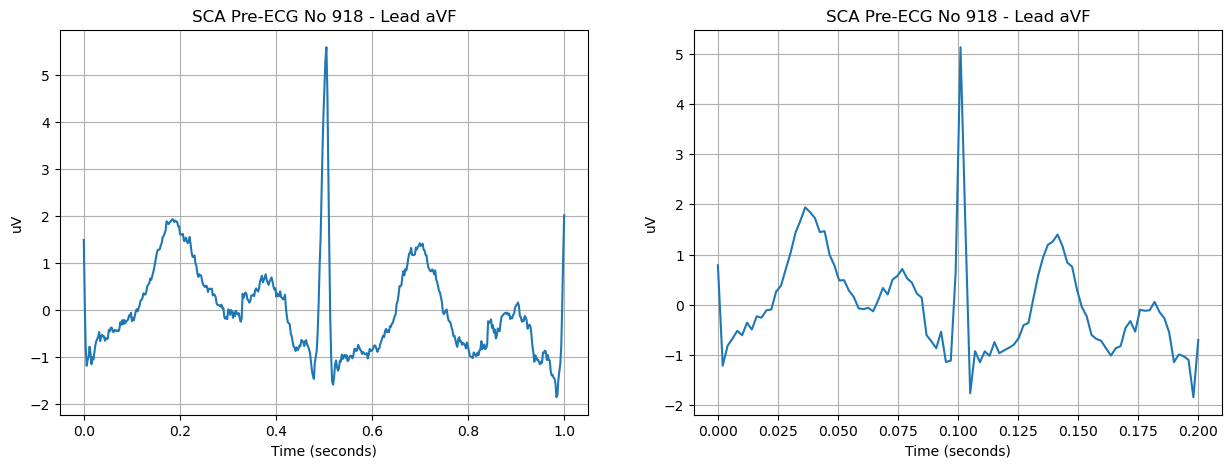

In [22]:
plot_2random_ecgs(X_resampled_np, X_undersampled_np)

## Model building

### Test with Multi-lead models

In [23]:
#Split into train and test sets, and scale data
y = y_undersampled_np
X = X_resampled_np #X_undersampled_np[:, lead_idxs, :]          # shape: (n_ecgs, n_samples)

# Split into train/test
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)
#Select all leads, Split into train and test sets, and scale data
lead_idxs = list(range(12))
X_train_leads=X_train_full[:, lead_idxs, :]
X_test_leads=X_test_full[:, lead_idxs, :]
signal_samples = X_train_leads.shape[2]
model_leads = len(lead_idxs) 

#Prepare data for RNN
X_train = X_train_leads.reshape(-1, signal_samples, model_leads)   # → (n_ecgs, n_samples, 1)
X_test = X_test_leads.reshape(-1, signal_samples, model_leads)   # → (n_ecgs, n_samples, 1)

#Actiavtion layers
RNN_activation = 'tanh'
last_layer_activation = 'sigmoid'
opt_metric = 'Accuracy' # 'Accuracy' or 'F1-score'

2025-06-26 10:19:40.690301: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Training: 100%|██████████ | 50/50


Test loss: 0.097, Test Accuracy: 0.966


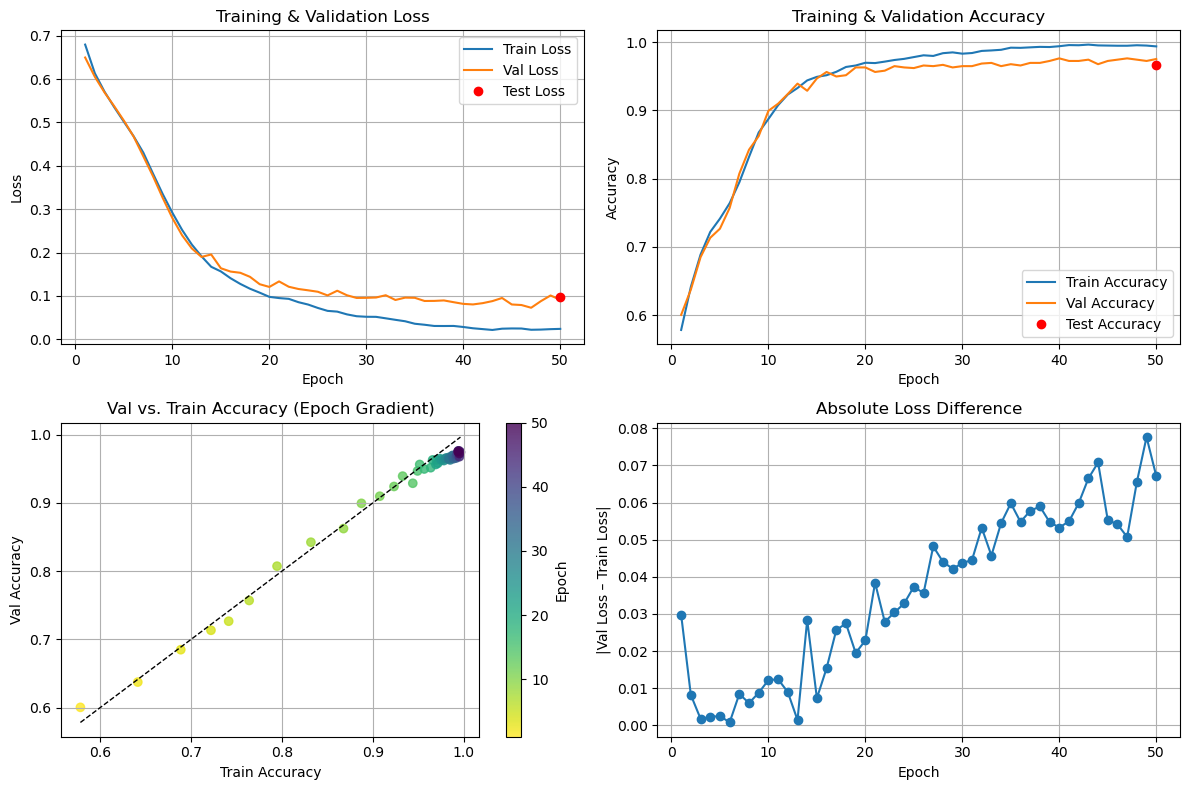

In [24]:
dl_model_units = 50
batch_size = 500
dl_model = SimpleRNN
drop_rate=0.0

epochs = 50
epoch_continuation = False
opt_metric = 'Accuracy' # 'Accuracy' or 'F1-score'. It doesn't work with F1-score due to tf and keras new versions

#Build the RNN model
model, saved_history, test_loss, test_metric = train_rnn_with_resume(opt_metric, X_train,X_test,y_train,y_test,
                                                                     signal_samples,model_leads,dl_model_units,
                                                                     batch_size,epochs,RNN_activation,
                                                                     last_layer_activation,dl_model,drop_rate,
                                                                     epoch_continuation)

Number of samples per ECG signal: 100
Scaler function: standard scaler rows
Number of leads in the model:  12
The batch size is:  500
--- Model Architecture Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,605 (37.52 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,404 (25.02 KB)

--- RNN Layer Details ---
  RNN Layer Type: SimpleRNN
  Number of RNN Units: 50
  RNN Activation Function: tanh
--- Last Layer Activation Function: sigmoid ---
Testing  metrics:
Accuracy: 0.966
Precision: 0.950
Sensitivity: 0.983
Specificity: 0.948
F1-Score: 0.966
NPV: 0.983
AUROC: 0.966


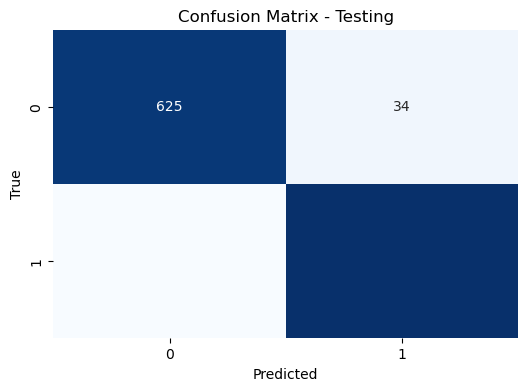

array([[625,  34],
       [ 11, 647]])

In [25]:
#Print model settings and test results
print('Number of samples per ECG signal:', signal_samples)
print('Scaler function: standard scaler rows')
print('Number of leads in the model: ', len(lead_idxs))
print('The batch size is: ', batch_size)
print_rnn_model_details(model)
cm=model_eval(model, X_test)
cm

### Explainability

In [26]:
#SHAP ANALYSIS
#!pip install timeshap
import timeshap
from timeshap.utils import calc_avg_event

In [30]:
f = lambda x: model.predict(x)

#Format the data
n_ecgs, n_leads, n_samples = X_resampled_np.shape

# 1) Move time axis to middle, then flatten all ECGs & samples into rows
#    shape (n_ecgs, n_leads, n_samples) -> (n_ecgs, n_samples, n_leads)
data_ts_first = np.transpose(X_resampled_np, (0, 2, 1))
#    shape -> (n_ecgs * n_samples, n_leads)
flat_data = data_ts_first.reshape(-1, n_leads)

# 2) Build the additional columns
time_col   = np.tile(np.arange(n_samples), n_ecgs)      # repeats 0..n_samples-1 for each ECG
ecg_id_col = np.repeat(np.arange(n_ecgs), n_samples)   # ECG index repeated n_samples times
label_col  = np.repeat(y_undersampled_np, n_samples)      # label for each ECG, repeated

# 3) Create DataFrame
data_df = pd.DataFrame(flat_data, columns=LEAD_ORDER)
data_df.insert(0, 'time',   time_col)
data_df['label']   = label_col
data_df['ECG_id']  = ecg_id_col

# `df` has n_ecgs*n_samples rows and columns: ['time', *LEAD_ORDER, 'label', 'ECG_id']
#data_df

In [28]:
X_train_0_df = pd.DataFrame(X_train[0], columns=LEAD_ORDER)

average_event = calc_avg_event(X_train_0_df, numerical_feats=lead_idxs, categorical_feats=[])
average_event

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.019744,-0.098281,-0.075859,-0.140764,-0.079665,-0.052017,0.012519,-0.039617,0.086141,0.045859,-0.019413,0.027522


In [53]:
from timeshap.utils import calc_avg_sequence
time_idxs = list(range(X_train.shape[1]))
average_sequence = calc_avg_sequence(X_train_0_df, numerical_feats=lead_idxs, categorical_feats=[],
                                     model_features=lead_idxs, entity_col=time_idxs)
average_sequence #Strange result
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=len(time_idxs))

In [35]:
#pip install shap
import shap
# Alias shap.KernelExplainer so that shap.explainers._kernel.Kernel resolves
shap.explainers._kernel.Kernel = shap.KernelExplainer

In [53]:
n_ECGs_selected = 10

import timeshap
from timeshap.plot import plot_temp_coalition_pruning,\
                          plot_event_heatmap, \
                          plot_feat_barplot, \
                          plot_cell_level
from timeshap.explainer import local_pruning, local_event, local_feat, local_cell_level
from shap.explainers import KernelExplainer

from timeshap.plot.local_report import plot_local_report

# 1) Wrap your model’s predict into a function matching TimeSHAP’s interface:
#    input:  3-D array (#seqs, seq_len, #features)
#    output: 2-D array (#seqs, 1)
predict_fn = lambda x: model.predict(x)

# 2) Select a background (baseline) dataset for perturbations:
#    e.g. 100 random training sequences
background = X_train[np.random.choice(len(X_train), size=n_ECGs_selected, replace=False)]

# 3) Pick one test sequence to explain locally
i = 0
test_seq = X_test[i:i+1]   # shape (1, seq_len, n_leads)

#3.5 Pruning
pruning_dict = {'tol': 0.025,}

# 4) LOCAL EVENT-LEVEL explanation
#    returns an array of shapley values per time-step (“event”)
event_dict = {'rs': 42, 'nsamples': 100}

coal_plot_data, coal_prun_idx = local_pruning(f=f, 
                                              data=pos_x_data, 
                                              pruning_dict=pruning_dict, 
                                              baseline=average_event, 
                                              entity_uuid=positive_sequence_id, 
                                              entity_col=sequence_id_feat, 
                                              verbose=False
                                             )

event_vals = local_event(f=predict_fn,   
                        data=test_seq,
                        event_dict=event_dict,
                        entity_uuid='random',
                        entity_col=0
                        baseline=average_event,
                        tolerance=0.01
                        )

#from the example
event_data = local_event(f=f, 
                         data=pos_x_data, 
                         event_dict=event_dict, 
                         entity_uuid=positive_sequence_id, 
                         entity_col=sequence_id_feat, 
                         baseline=average_event, 
                         pruning_idx=pruning_idx
                        )


# Plot heatmap over time
timeshap.plot_event_heatmap(event_vals, test_seq)

# 5) LOCAL FEATURE-LEVEL explanation
#    returns shapley values per feature (lead)
feat_vals = timeshap.local_feat(
    predict_fn,
    test_seq,
    background,
    tolerance=0.01
)
# Plot barplot across leads
timeshap.plot_feat_barplot(feat_vals, feature_names=LEAD_ORDER)

# 6) GLOBAL EVENT-LEVEL explanation
#    aggregate event importance over many sequences
#    take e.g. 50 random test examples
samples = X_test[np.random.choice(len(X_test), size=50, replace=False)]
global_event = timeshap.event_explain_all(
    predict_fn,
    samples,
    background,
    tolerance=0.01
)
timeshap.plot_global_event(global_event)

# 7) GLOBAL FEATURE-LEVEL explanation
global_feat = timeshap.feat_explain_all(
    predict_fn,
    samples,
    background,
    tolerance=0.01
)
timeshap.plot_global_feat(global_feat, feature_names=LEAD_ORDER)

TypeError: local_event() got an unexpected keyword argument 'tolerance'

In [52]:
background = X_train[np.random.choice(len(X_train), size=100, replace=False)]
background.shape

(100, 100, 12)

In [51]:
X_train.shape

(5270, 100, 12)

In [49]:
len(X_train)

5270